In [1]:
import anndata as ad
import re
import os
import palantir
import scipy.stats as st

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append(os.getcwd())

from GLOBAL_VARIABLES.GLOBAL_VARIABLES import cc_mapping_package_dir, pdac_data_dir
sys.path.append(cc_mapping_package_dir)

from cc_mapping import preprocess
from cc_mapping import plot
from cc_mapping import pseudotime

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
cell_line = 'Pa16C'
pdac_data_dir = pdac_data_dir
data_dir = f'{pdac_data_dir}/{cell_line}'
filename = f'{cell_line}_RMM_FK_ALL_DK_DIP.h5ad'

data_file = os.path.join(data_dir, filename)

adata = ad.read_h5ad(data_file)

In [3]:
fs_name = 'RF_min_max_feature_set'
fs_method = 'RF_min_max'
data_criteria = 'diploid'
fs_criteria = 'all_cells'
phase_set = '3GS'

In [4]:
if phase_set == '3GS':
    phase_set_list = ['G0', 'G1', 'S', 'G2']

adata = preprocess.row_data_partitioning(adata, search_str = phase_set_list, search_obs = 'phase')

In [5]:
fs_bool = adata.var[fs_name].values

adata.layers['RMM_FK_ALL_DK_DIP_3GS_z-score'] = st.zscore(adata.X.copy(), axis=0)
adata.obsm[f'X_palantir'] = adata.layers['RMM_FK_ALL_DK_DIP_3GS_z-score'][:, fs_bool].copy()

Generating hyperparameter search plots:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
Generating hyperparameter search plots:  50%|█████     | 1/2 [05:58<05:58, 358.95s/it]c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\palantir\core.py:520: UserWarning: Singular matrix encountered. Attempting pseudo-inverse.
  warnings.warn(
c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-packages\palantir\core.py:520: UserWarning: Singular matrix encountered. Attempting pseudo-inverse.
  warnings.warn(
c:\Users\dap182\AppData\Local\anaconda3\envs\test_dtp\lib\site-pa

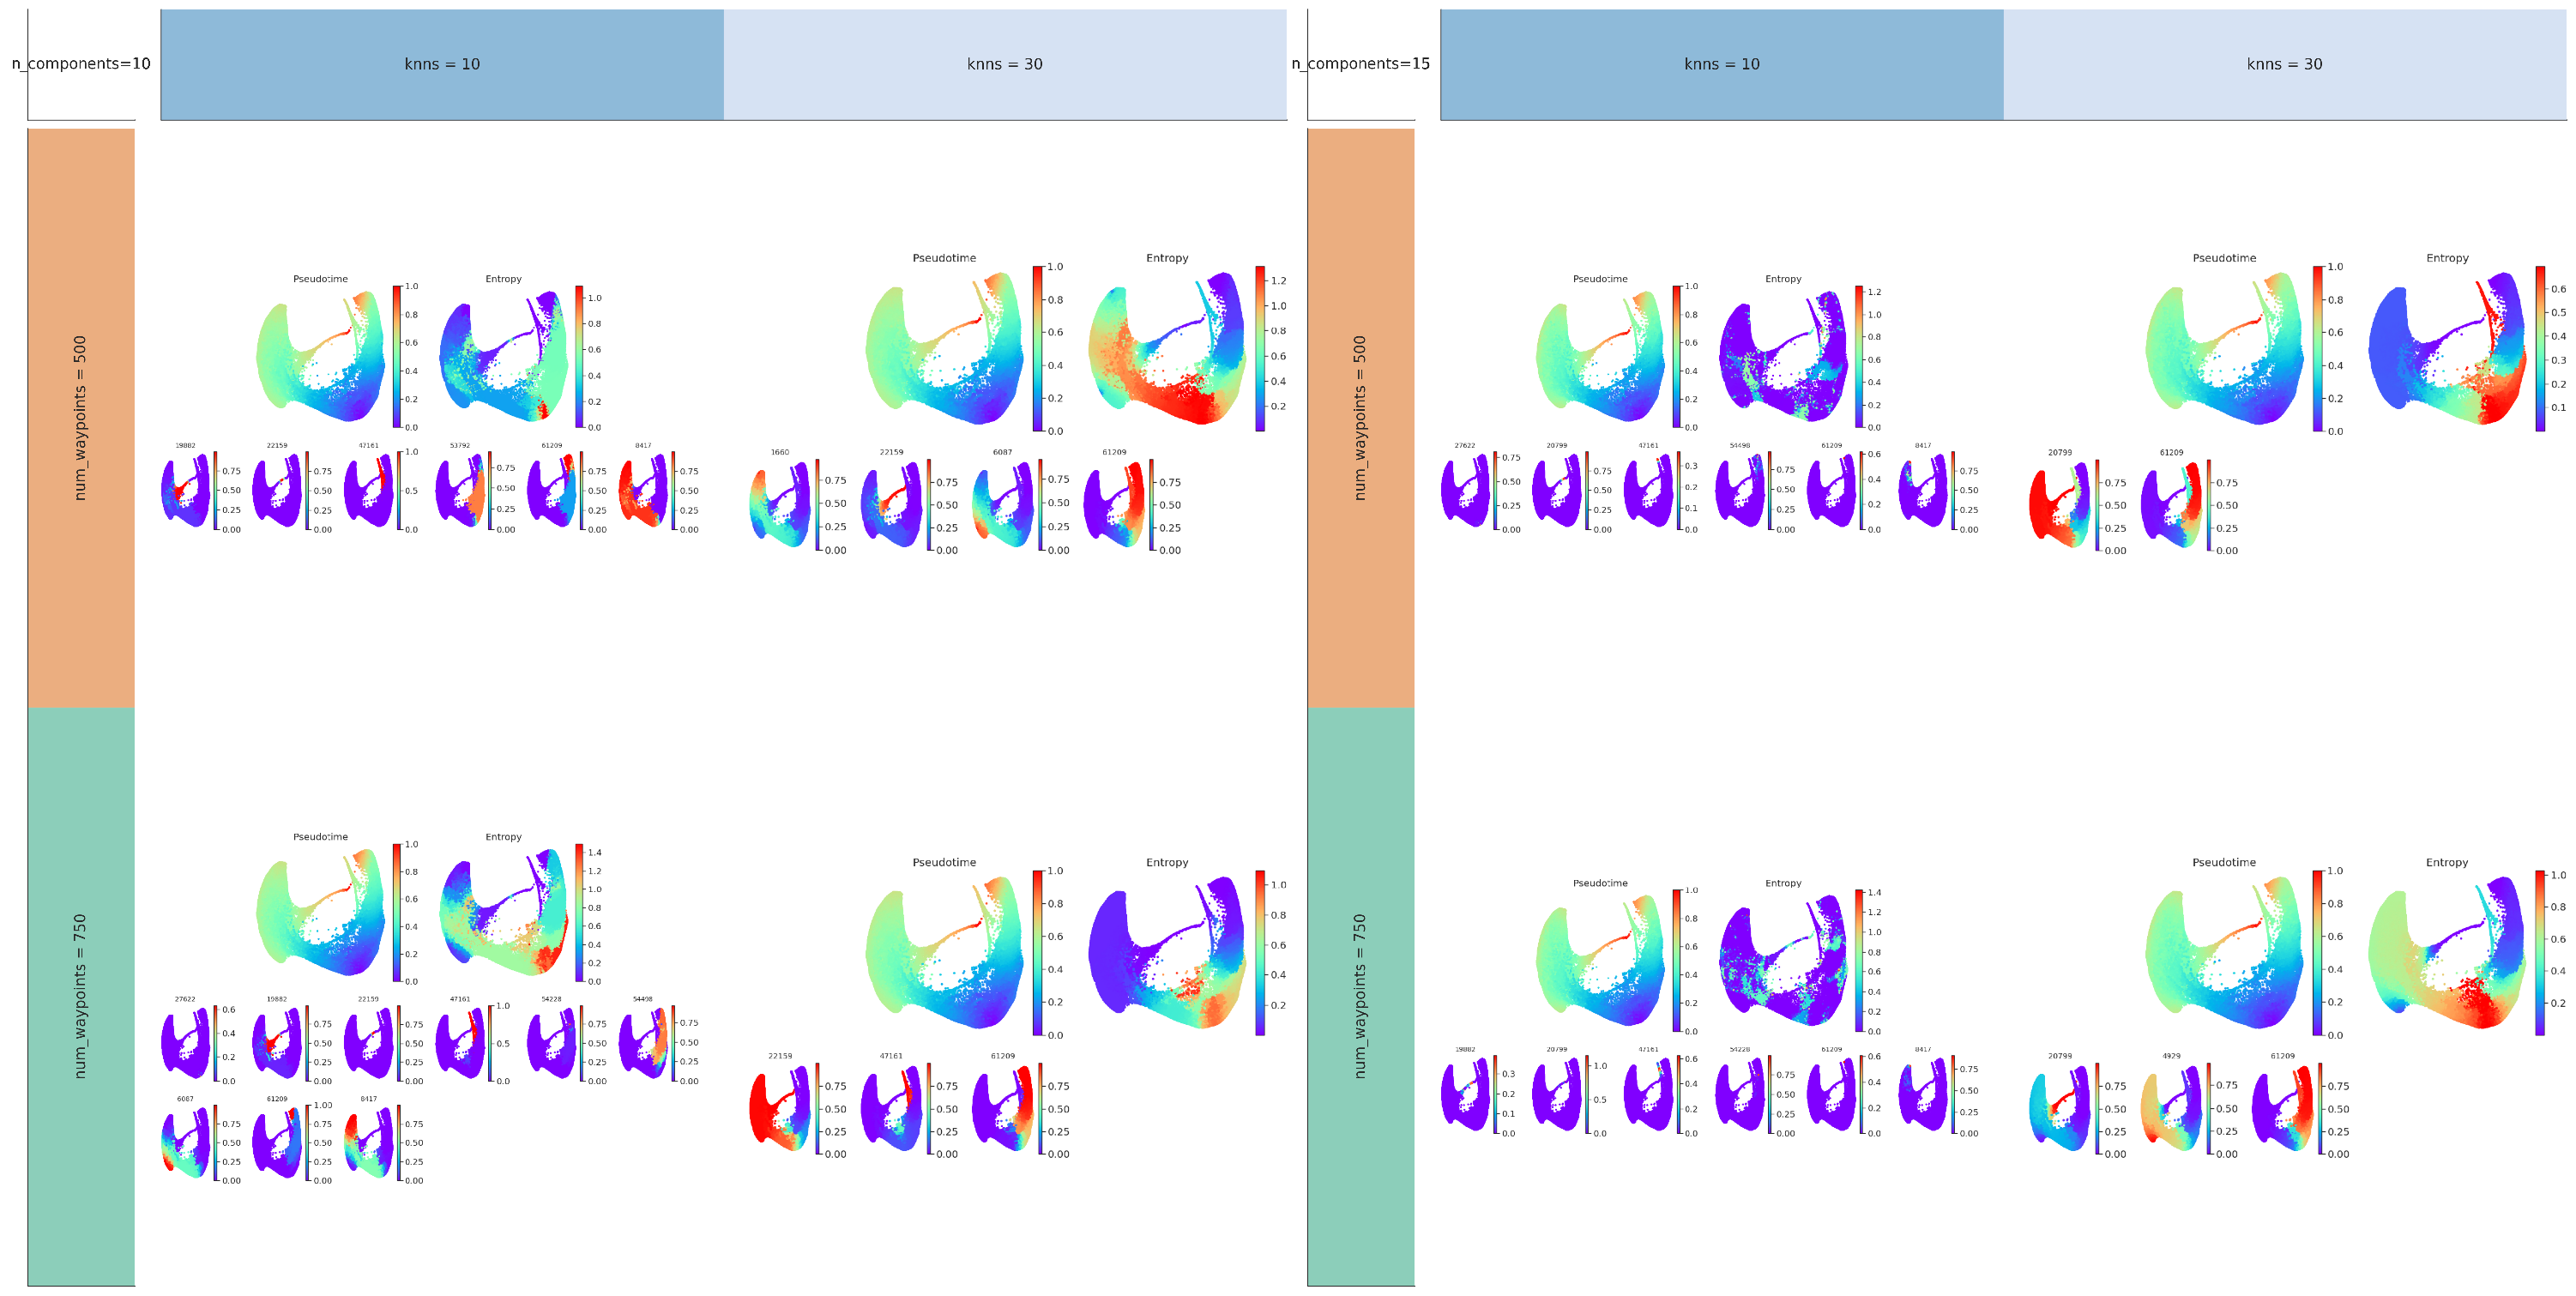

In [6]:
palantir_param_dict = {'num_waypoints': [500,750],
                            'knns': [10,30],
                            'n_components': [10,15],
                            'random_seed':0}

param_info_dict = { 'row_label': 'num_waypoints',
                    'col_label': 'knns',
                    'constant_label': 'n_components',
                    'final_figure_dims': (1,2)}

kwargs = {'s': 5,
        'cmap': 'rainbow',}

root_cell = "33813"

fig = pseudotime.perform_palantir_hyperparameter_search(adata,
                                        data_key = 'X_palantir',
                                        root_cell = root_cell,
                                        hyperparam_dict = palantir_param_dict,
                                        hyperparam_info_dict = param_info_dict,
                                        save_path = f'.\{cell_line}_{root_cell}_p1_RB_hyperparameter_search.png',
                                        unit_size=15,
                                        kwargs = kwargs)

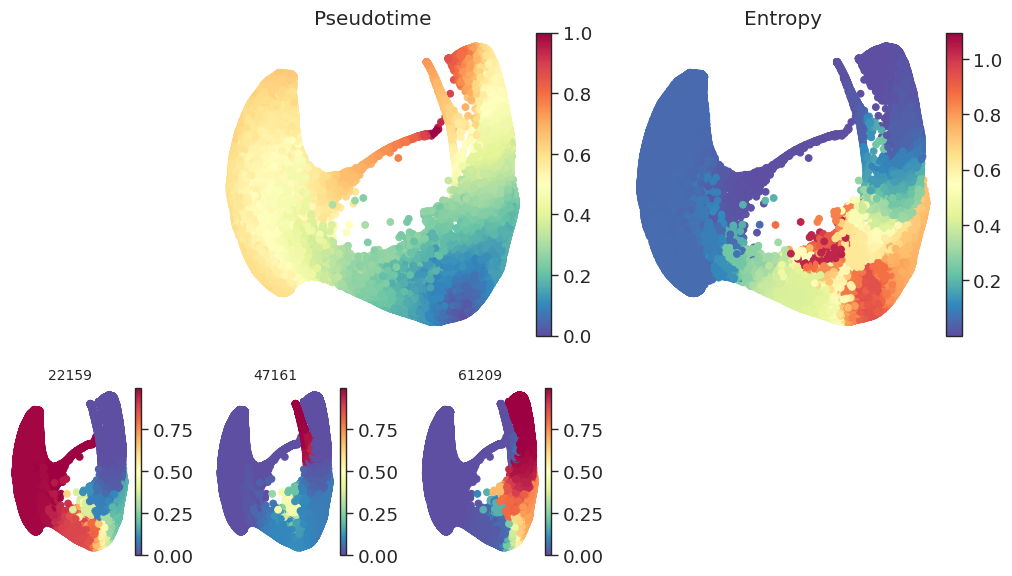

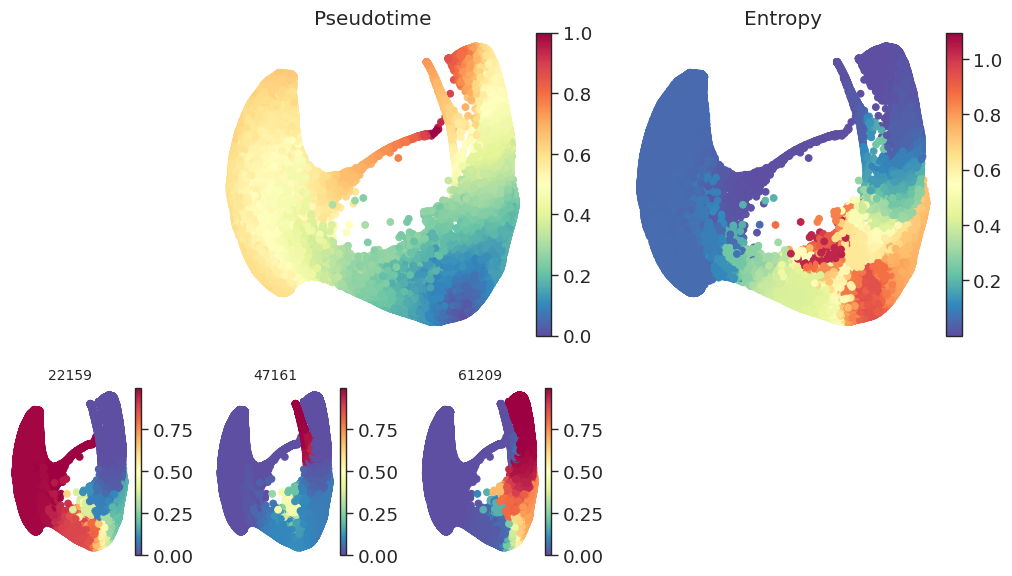

In [7]:
#optimal palantir paramters
num_waypoints =  750
n_components = 10
knn = 30

optimal_root_cell = "33813"

pseudotime.run_palantir_pseudotime(adata,
                                    root_cell = optimal_root_cell,
                                    data_key = 'X_palantir',
                                    n_components=n_components,
                                    num_waypoints=num_waypoints,
                                    knn=knn,
                                    )

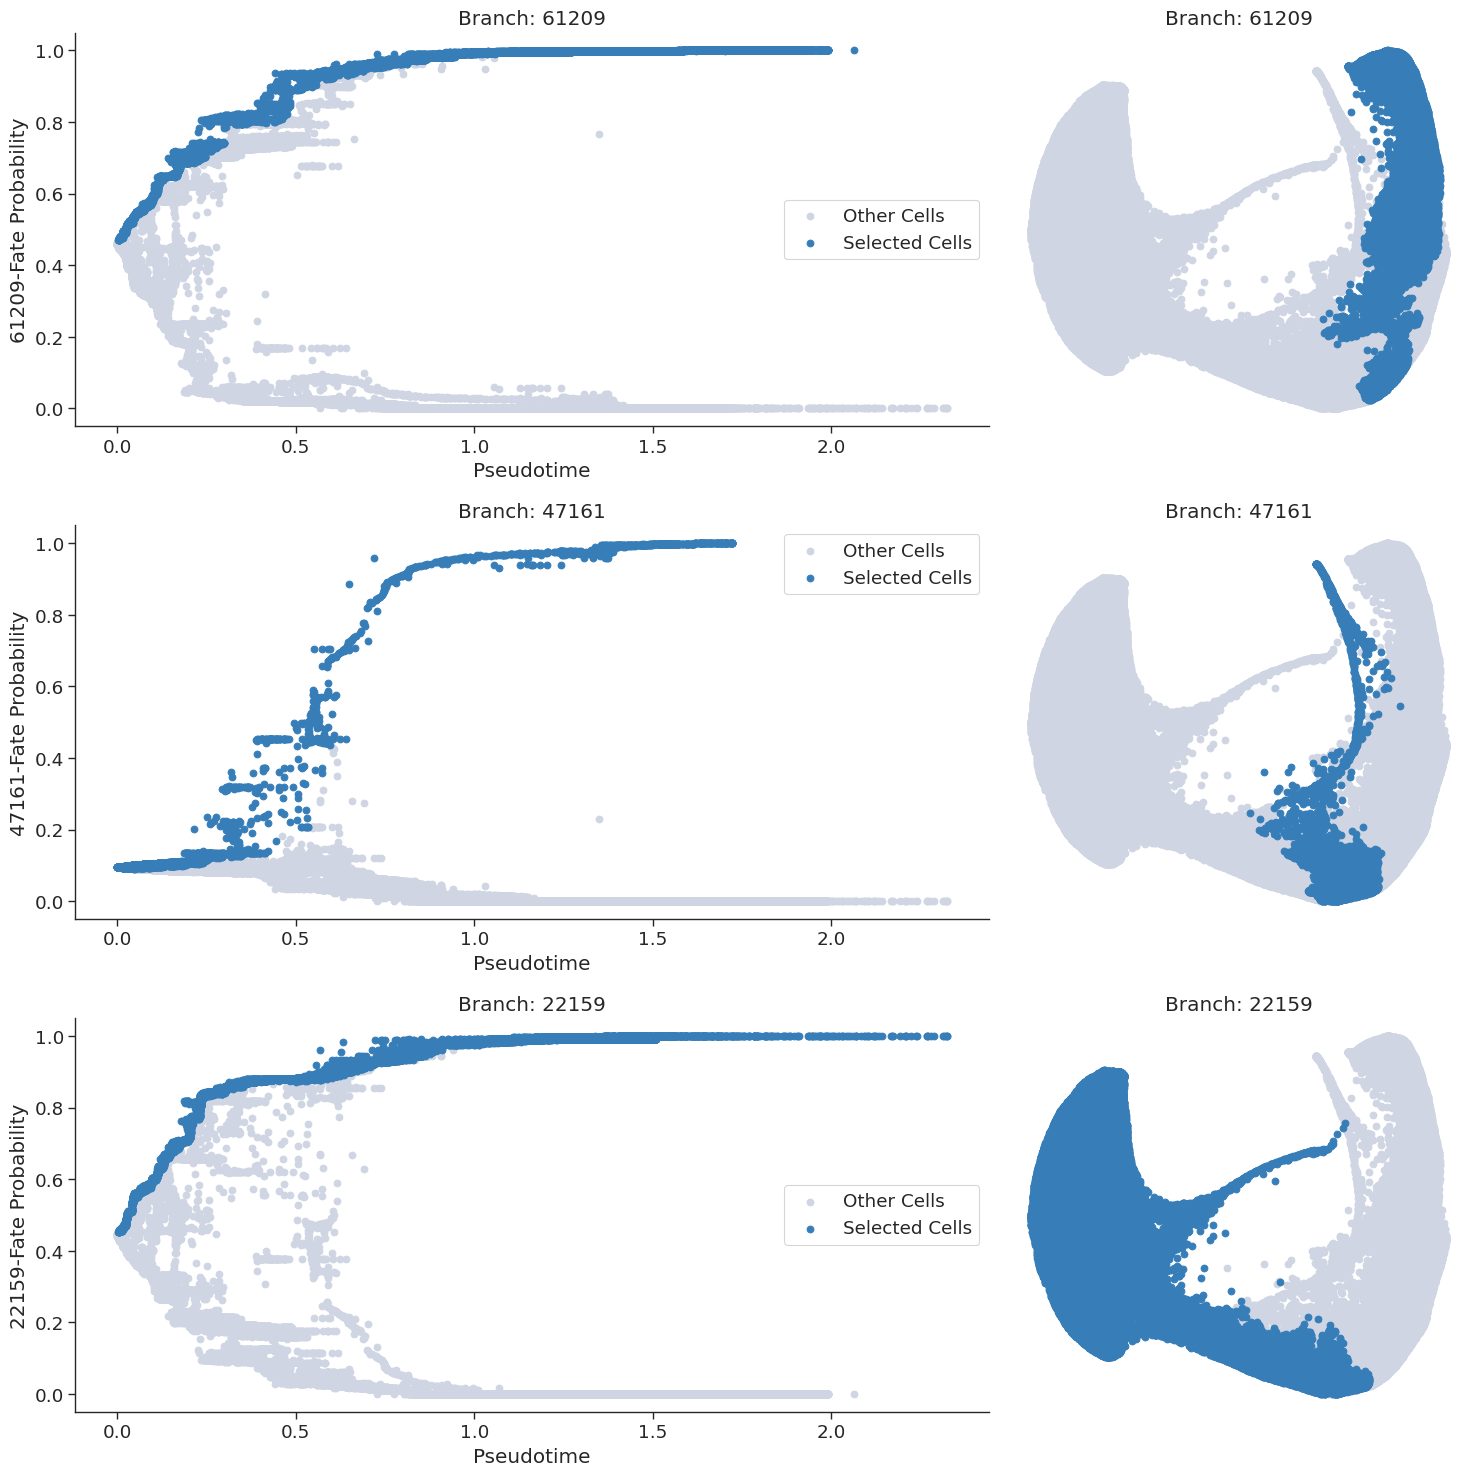

In [8]:
masks = palantir.presults.select_branch_cells(adata)

palantir.plot.plot_branch_selection(adata, embedding_basis='X_phate')
plt.tight_layout()